# GANomaly
- 2020.08.15 : Genrator 학습 수 ... 4

# 개발일지
- 2020.08.15 : 분율 추출 구현 / 이상치 상관계수 추출 구현 / 모델 save, load 구현
- 2020.08.16 : anomaly detect 이미지 저장 구현 / 티타늄(Ti64) 상대 밀도 계산 구현

--- 

# Module

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
import os
import numpy as np

import torchvision.datasets as dataset
import torchvision.transforms as transforms
import torchvision.utils as vutils

# Graph & Animation
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Hyper Parameter

In [2]:
latent_size = 100  # z벡터의 잠재공간(latent space)의 크기
workers = 4    # 0일때, 약 20% 사용 4일 경우 메모리 100%
img_size = 64
channel = 1
epochs = 100
batch_size = 64
learning_rate = 1e-5

# Data and Device

In [3]:
# 이미지 경로, 이미지들 리사이즈 및 텐서형태로 만들기
#data_root = "../../dataset/train"
DP_aug_data_root = "../../dataset/aug_train/aug_DualPhaseSteel"

data_set = dataset.ImageFolder(root = DP_aug_data_root, # data_root,
                           transform = transforms.Compose([
                                  #transforms.Resize(img_size),
                                  transforms.CenterCrop(img_size),
                                  torchvision.transforms.Grayscale(channel),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,),(0.5,))
                              ]))

print("size of dataset :", len(data_set))

# 배치로 나누고 셔플하기
data_loader = torch.utils.data.DataLoader(data_set, batch_size = batch_size,
                                         shuffle = True, num_workers = workers, drop_last=True)

# Device setting (GPU or CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("device :", device)

size of dataset : 990
device : cuda:0


# MODEL

In [4]:
# GANomaly : Generative Adversarial Networks Model using Decoder with AutoEncoder

# === Decoder 모델 ===
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        
        # Batch Normalization 유무에 따른 G_block 정의
        def DC_conv_block(in_features, out_features):
            block = [
                    nn.Conv2d(in_features, out_features, 3, 1, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ELU()
            ]
            return block
        
        def DC_deconv_block(in_features, out_features, FIRST=True):
            if FIRST:
                block = [
                    nn.ConvTranspose2d(in_features, out_features, 4, 1, 0, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ELU()
                ]
            else:
                block = [
                    nn.ConvTranspose2d(in_features, out_features, 4, 2, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ELU()
                ]
            return block
        
        
        # ======================= 픽셀 분포 생성 layer ======================= 
        self.DC_gen_distribution = nn.Sequential(
            # ------ input is latent_size 100 ------ 
            *DC_deconv_block(latent_size, img_size*8, FIRST=True),
            # ------ state size is 512x4x4 ------ 
            *DC_conv_block(img_size*8, img_size*8),
            # ------ state size is 512x4x4 ------   
            *DC_deconv_block(img_size*8, img_size*4, FIRST=False),
            # ------ state size is 256x8x8 ------ 
            *DC_conv_block(img_size*4, img_size*4),
            # ------ state size is 256x8x8 ------ 
            *DC_deconv_block(img_size*4, img_size*2, FIRST=False),
            # ------ state size is 128x16x16 ------ 
            *DC_conv_block(img_size*2, img_size*2),
            # ------ state size is 128x16x16 ------ 
            *DC_deconv_block(img_size*2, img_size, FIRST=False),
        )
        
        # =================== 가짜 이미지 생성 layer =================== 
        self.DC_gen_fake_img = nn.Sequential(
            # ------ state size is 64x32x32 ------ 
            nn.ConvTranspose2d(img_size, 1, 4, 2, 1, bias=False),
            nn.Tanh() # 픽셀값의 범위 : -1 ~ 1로 두기 위해서
            # ------ state size is 1x64x64 ------ 
        )
    
    def forward(self, input):
        distribution = self.DC_gen_distribution(input)
        fake_img = self.DC_gen_fake_img(distribution)
        
        return fake_img


# === Discriminator 모델 ===
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        # Batch Normalization 유무에 따른 D_block 정의
        def D_block(in_features, out_features, MP=True):
            if MP:
                block = [
                    nn.Conv2d(in_features, out_features, 3, 1, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ELU()
                ]
            else:
                block = [
                    nn.Conv2d(in_features, out_features, 3, 1, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ELU(),
                    nn.MaxPool2d(2)
                ]
            return block
        
        # ============== Feature 추출 layer ==============
        self.D_extract_feature = nn.Sequential(
            # ------ input is 1 x 64 x 64 ------ 
            *D_block(channel, img_size, MP=False),
            # ------ input is 64 x 64 x 64 ------ 
            *D_block(img_size, img_size, MP=True),
            # ------ state is 64 x 32 x 32 ------ 
            *D_block(img_size, img_size*2, MP=False),
            # ------ state is 128 x 32 x 32 ------ 
            *D_block(img_size*2, img_size*2, MP=True),
            # ------ state is 128 x 16 x 16 ------ 
            *D_block(img_size*2, img_size*4, MP=False),
            # ------ state is 256 x 16 x 16 ------ 
            *D_block(img_size*4, img_size*4, MP=True),
            # ------ state is 256 x 8 x 8 ------ 
            *D_block(img_size*4, img_size*8, MP=False),
            # ------ state is 512 x 8 x 8 ------ 
            *D_block(img_size*8, img_size*8, MP=True),
        )
        
        # ===================== 이진 분류 layer =====================
        self.D_classification = nn.Sequential(        
            # ------- state size 512x4x4 ------- 
            nn.Conv2d(img_size*8, channel, 4, 1, 0, bias=False),
            #nn.Linear(fms*8*4*4, 1, bias=False),
            nn.Sigmoid()        
        )
        
    def forward(self, input):
        feature = self.D_extract_feature(input)
        classification = self.D_classification(feature)
        
        return classification, feature 


# === Encoder Model ===
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        def EC_block(in_features, out_features, MP=True):
            if MP:
                block = [
                    nn.Conv2d(in_features, out_features, 3, 1, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ELU()
                ]
            else:
                block = [
                    nn.Conv2d(in_features, out_features, 3, 1, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ELU(),
                    nn.MaxPool2d(2)
                ]
            return block
        
        # ============== Feature 추출 ==============
        self.EC_extract_feature = nn.Sequential(
            # ------ input is 1 x 64 x 64 ------ 
            *EC_block(channel, img_size, MP=False),
            # ------ input is 64 x 64 x 64 ------ 
            *EC_block(img_size, img_size, MP=True),
            # ------ state is 64 x 32 x 32 ------ 
            *EC_block(img_size, img_size*2, MP=False),
            # ------ state is 128 x 32 x 32 ------ 
            *EC_block(img_size*2, img_size*2, MP=True),
            # ------ state is 128 x 16 x 16 ------ 
            *EC_block(img_size*2, img_size*4, MP=False),
            # ------ state is 256 x 16 x 16 ------ 
            *EC_block(img_size*4, img_size*4, MP=True),
            # ------ state is 256 x 8 x 8 ------ 
            *EC_block(img_size*4, img_size*8, MP=False),
            # ------ state is 512 x 8 x 8 ------ 
            *EC_block(img_size*8, img_size*8, MP=True),
        )
        
        # =============== Encoder Training layer ===============
        self.EC_validate = nn.Sequential(
            # -------state is 512 x 4 x 4-------
            nn.Conv2d(img_size*8, latent_size, 4, 1, 0, bias=False),
            nn.Tanh()
            # -------state is 100 x 97 x 97-------
        )
        
    def forward(self, input):
        feature = self.EC_extract_feature(input)
        validity = self.EC_validate(feature)
        
        return validity

# Loss & Optim

In [5]:
# DC and D 무게 초기화, classname 에 찾는 name가 없다면 -1 ,
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# D,DC,EC 네트워크 모델 객체 선언
D = Discriminator().to(device)
DC = Decoder().to(device)
EC = Encoder().to(device)

# weight initialize/ nn.Module 클래스 안에 apply 함수가 정의되 있음, 각 함수들에 다 적용 하게한다
D.apply(weights_init)
DC.apply(weights_init)
EC.apply(weights_init)

# Binary cross entropy loss and optimizer
DCGAN_criterion = nn.BCELoss()
AE_criterion = nn.MSELoss()

# latent vector에 배치 사이즈 64를 적용
# 학습한 DC로 새로운 것 만들어서 결과 확인 할때 사용
noise_z = torch.randn(img_size, latent_size, 1, 1, device = device)

# D와 DC에 대해 두가지 최적화 설정
D_optimizer = torch.optim.Adam(D.parameters(), lr = learning_rate, betas=(0.5,0.999))
DC_optimizer = torch.optim.Adam(DC.parameters(), lr = learning_rate, betas=(0.5,0.999))
EC_optimizer = torch.optim.Adam(EC.parameters(), lr = learning_rate, betas=(0.5,0.999))

#print(D)
#print(DC)
#print(EC)

def reset_grad():
    D_optimizer.zero_grad()
    DC_optimizer.zero_grad()

---

# Train DCGAN

In [6]:
img_list = []
DC_losses = []
D_losses = []
iters = 0

def train_DCGAN(epoch, learning_DC_per_D = 4):
    global epochs
    global iters
    
    # 인덱스 0부터 세기 시작
    # data[0].size():64x1x64x64(image) / data[1].size():64(label)
    for i,data in enumerate(data_loader,0):
        
        # Train D
        real_img = data[0].to(device) # image size: 64x1x64x64(batch, channel, width, height)
        b_size = real_img.size(0) # b_size = 64
        real_labels = torch.ones(b_size, 1).to(device)
        fake_labels = torch.zeros(b_size, 1).to(device)
        
        # (--------------------------real-----------------------------)
        real_classification, _ = D(real_img) # output = D(x)
        real_loss = DCGAN_criterion(real_classification, real_labels) # D(x)=1일 때의 loss
        real_score = real_classification
        D_x = real_score.mean().item() 
            
        # (--------------------------fake-----------------------------)
        z = torch.randn(b_size, latent_size, 1, 1).to(device) # z size :64x100x1x1
        fake_img = DC(z)
        fake_classification, _ = D(fake_img) # output = D(DC(z))
        fake_loss = DCGAN_criterion(fake_classification, fake_labels) # D(DC(z))=0일 때의 loss
        fake_score = fake_classification
        D_DC_z1 = fake_score.mean().item()

        # (------------------Backprop and optimize---------------------)
        D_loss = real_loss + fake_loss
        reset_grad()
        D_loss.backward()
        D_optimizer.step() # D(x)=1, D(DC(z))=0이어야 D가 최적

        
        # Train DC
        #z = torch.randn(b_size,latent_size,1,1,device=device) # z size :64x100x1x1
        for k in range(learning_DC_per_D):
            fake_img = DC(z)
            fake_classification,_ = D(fake_img)  # output : D(DC(z))
            D_DC_z2 = fake_classification.mean().item()
            DC_loss = DCGAN_criterion(fake_classification, real_labels) # D(DC(z))=1일 때의 loss=log(D(DC(z)))

            # (------------------Backprop and optimize---------------------)
            reset_grad()
            DC_loss.backward()
            DC_optimizer.step() # D(DC(z))=1 이어야 DC가 최적
            # ==> D(DC(z))의 값이 0.5로 수렴해야 한다.
        
        
        # print
        print('[%d/%d][%d/%d]\n- D_loss : %.4f / DC_loss : %.4f\n- D(x):%.4f / D(DC(z1)) : %.4f / D(DC(z2)) : %.4f' 
                   %(epoch+1, epochs, i, len(data_loader),D_loss.item(),
                     DC_loss.item(),D_x,D_DC_z1,D_DC_z2))
        
        # Save Losses for plotting later
        DC_losses.append(DC_loss.item())
        D_losses.append(D_loss.item())
        
        #Check how the generator is doing by saving G's output on noise_z
        if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(data_loader)-1)):
            with torch.no_grad():
                fake = DC(noise_z).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
        
#torch.save(E.state_dict(), 'E.ckpt')

In [7]:
for epoch in range(epochs):
    train_DCGAN(epoch, learning_DC_per_D = 10)

/home/piai/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[1/100][0/15]
- D_loss : 1.3795 / DC_loss : 0.6608
- D(x):0.4935 / D(DC(z1)) : 0.4899 / D(DC(z2)) : 0.5165
[1/100][1/15]
- D_loss : 1.3739 / DC_loss : 0.6637
- D(x):0.4922 / D(DC(z1)) : 0.4857 / D(DC(z2)) : 0.5150
[1/100][2/15]
- D_loss : 1.3666 / DC_loss : 0.6676
- D(x):0.4933 / D(DC(z1)) : 0.4830 / D(DC(z2)) : 0.5130
[1/100][3/15]
- D_loss : 1.3612 / DC_loss : 0.6722
- D(x):0.4926 / D(DC(z1)) : 0.4795 / D(DC(z2)) : 0.5106
[1/100][4/15]
- D_loss : 1.3542 / DC_loss : 0.6810
- D(x):0.4915 / D(DC(z1)) : 0.4746 / D(DC(z2)) : 0.5061
[1/100][5/15]
- D_loss : 1.3504 / DC_loss : 0.6846
- D(x):0.4914 / D(DC(z1)) : 0.4726 / D(DC(z2)) : 0.5044
[1/100][6/15]
- D_loss : 1.3456 / DC_loss : 0.6887
- D(x):0.4918 / D(DC(z1)) : 0.4704 / D(DC(z2)) : 0.5023
[1/100][7/15]
- D_loss : 1.3330 / DC_loss : 0.6961
- D(x):0.4937 / D(DC(z1)) : 0.4658 / D(DC(z2)) : 0.4986
[1/100][8/15]
- D_loss : 1.3291 / DC_loss : 0.7003
- D(x):0.4936 / D(DC(z1)) : 0.4635 / D(DC(z2)) : 0.4965
[1/100][9/15]
- D_loss : 1.3247 / DC_

[6/100][2/15]
- D_loss : 1.4161 / DC_loss : 0.6533
- D(x):0.4972 / D(DC(z1)) : 0.5118 / D(DC(z2)) : 0.5204
[6/100][3/15]
- D_loss : 1.4301 / DC_loss : 0.6527
- D(x):0.4923 / D(DC(z1)) : 0.5138 / D(DC(z2)) : 0.5207
[6/100][4/15]
- D_loss : 1.4371 / DC_loss : 0.6511
- D(x):0.4915 / D(DC(z1)) : 0.5164 / D(DC(z2)) : 0.5215
[6/100][5/15]
- D_loss : 1.4321 / DC_loss : 0.6549
- D(x):0.4932 / D(DC(z1)) : 0.5156 / D(DC(z2)) : 0.5195
[6/100][6/15]
- D_loss : 1.4356 / DC_loss : 0.6565
- D(x):0.4907 / D(DC(z1)) : 0.5148 / D(DC(z2)) : 0.5187
[6/100][7/15]
- D_loss : 1.4380 / DC_loss : 0.6547
- D(x):0.4897 / D(DC(z1)) : 0.5150 / D(DC(z2)) : 0.5196
[6/100][8/15]
- D_loss : 1.4371 / DC_loss : 0.6520
- D(x):0.4909 / D(DC(z1)) : 0.5157 / D(DC(z2)) : 0.5210
[6/100][9/15]
- D_loss : 1.4428 / DC_loss : 0.6509
- D(x):0.4899 / D(DC(z1)) : 0.5176 / D(DC(z2)) : 0.5216
[6/100][10/15]
- D_loss : 1.4383 / DC_loss : 0.6497
- D(x):0.4935 / D(DC(z1)) : 0.5189 / D(DC(z2)) : 0.5223
[6/100][11/15]
- D_loss : 1.4485 / D

[11/100][4/15]
- D_loss : 1.3454 / DC_loss : 0.7782
- D(x):0.4806 / D(DC(z1)) : 0.4578 / D(DC(z2)) : 0.4592
[11/100][5/15]
- D_loss : 1.3553 / DC_loss : 0.7726
- D(x):0.4779 / D(DC(z1)) : 0.4600 / D(DC(z2)) : 0.4618
[11/100][6/15]
- D_loss : 1.3556 / DC_loss : 0.7637
- D(x):0.4803 / D(DC(z1)) : 0.4629 / D(DC(z2)) : 0.4659
[11/100][7/15]
- D_loss : 1.3561 / DC_loss : 0.7570
- D(x):0.4838 / D(DC(z1)) : 0.4670 / D(DC(z2)) : 0.4691
[11/100][8/15]
- D_loss : 1.3679 / DC_loss : 0.7525
- D(x):0.4807 / D(DC(z1)) : 0.4700 / D(DC(z2)) : 0.4712
[11/100][9/15]
- D_loss : 1.3646 / DC_loss : 0.7513
- D(x):0.4843 / D(DC(z1)) : 0.4721 / D(DC(z2)) : 0.4718
[11/100][10/15]
- D_loss : 1.3650 / DC_loss : 0.7539
- D(x):0.4845 / D(DC(z1)) : 0.4725 / D(DC(z2)) : 0.4705
[11/100][11/15]
- D_loss : 1.3634 / DC_loss : 0.7586
- D(x):0.4840 / D(DC(z1)) : 0.4712 / D(DC(z2)) : 0.4683
[11/100][12/15]
- D_loss : 1.3648 / DC_loss : 0.7646
- D(x):0.4811 / D(DC(z1)) : 0.4688 / D(DC(z2)) : 0.4655
[11/100][13/15]
- D_loss 

[16/100][5/15]
- D_loss : 1.3068 / DC_loss : 0.7822
- D(x):0.5003 / D(DC(z1)) : 0.4585 / D(DC(z2)) : 0.4574
[16/100][6/15]
- D_loss : 1.3169 / DC_loss : 0.7843
- D(x):0.4951 / D(DC(z1)) : 0.4584 / D(DC(z2)) : 0.4564
[16/100][7/15]
- D_loss : 1.3127 / DC_loss : 0.7901
- D(x):0.4961 / D(DC(z1)) : 0.4572 / D(DC(z2)) : 0.4538
[16/100][8/15]
- D_loss : 1.3213 / DC_loss : 0.7989
- D(x):0.4896 / D(DC(z1)) : 0.4545 / D(DC(z2)) : 0.4498
[16/100][9/15]
- D_loss : 1.2945 / DC_loss : 0.8102
- D(x):0.4990 / D(DC(z1)) : 0.4504 / D(DC(z2)) : 0.4447
[16/100][10/15]
- D_loss : 1.2968 / DC_loss : 0.8226
- D(x):0.4932 / D(DC(z1)) : 0.4452 / D(DC(z2)) : 0.4393
[16/100][11/15]
- D_loss : 1.2856 / DC_loss : 0.8350
- D(x):0.4939 / D(DC(z1)) : 0.4397 / D(DC(z2)) : 0.4339
[16/100][12/15]
- D_loss : 1.2727 / DC_loss : 0.8462
- D(x):0.4954 / D(DC(z1)) : 0.4343 / D(DC(z2)) : 0.4290
[16/100][13/15]
- D_loss : 1.2645 / DC_loss : 0.8575
- D(x):0.4953 / D(DC(z1)) : 0.4295 / D(DC(z2)) : 0.4242
[16/100][14/15]
- D_loss

[21/100][6/15]
- D_loss : 1.1389 / DC_loss : 0.9275
- D(x):0.5230 / D(DC(z1)) : 0.3875 / D(DC(z2)) : 0.3955
[21/100][7/15]
- D_loss : 1.1797 / DC_loss : 0.8943
- D(x):0.5105 / D(DC(z1)) : 0.3975 / D(DC(z2)) : 0.4089
[21/100][8/15]
- D_loss : 1.1738 / DC_loss : 0.8287
- D(x):0.5258 / D(DC(z1)) : 0.4117 / D(DC(z2)) : 0.4366
[21/100][9/15]
- D_loss : 1.2218 / DC_loss : 0.7781
- D(x):0.5270 / D(DC(z1)) : 0.4405 / D(DC(z2)) : 0.4593
[21/100][10/15]
- D_loss : 1.2614 / DC_loss : 0.7667
- D(x):0.5266 / D(DC(z1)) : 0.4619 / D(DC(z2)) : 0.4645
[21/100][11/15]
- D_loss : 1.2723 / DC_loss : 0.7804
- D(x):0.5251 / D(DC(z1)) : 0.4662 / D(DC(z2)) : 0.4582
[21/100][12/15]
- D_loss : 1.2564 / DC_loss : 0.8091
- D(x):0.5270 / D(DC(z1)) : 0.4596 / D(DC(z2)) : 0.4453
[21/100][13/15]
- D_loss : 1.2292 / DC_loss : 0.8556
- D(x):0.5288 / D(DC(z1)) : 0.4465 / D(DC(z2)) : 0.4250
[21/100][14/15]
- D_loss : 1.2118 / DC_loss : 0.8973
- D(x):0.5189 / D(DC(z1)) : 0.4261 / D(DC(z2)) : 0.4077
[22/100][0/15]
- D_loss

[26/100][7/15]
- D_loss : 1.2332 / DC_loss : 0.8075
- D(x):0.5372 / D(DC(z1)) : 0.4575 / D(DC(z2)) : 0.4460
[26/100][8/15]
- D_loss : 1.2651 / DC_loss : 0.8139
- D(x):0.5118 / D(DC(z1)) : 0.4481 / D(DC(z2)) : 0.4431
[26/100][9/15]
- D_loss : 1.2106 / DC_loss : 0.8267
- D(x):0.5371 / D(DC(z1)) : 0.4450 / D(DC(z2)) : 0.4375
[26/100][10/15]
- D_loss : 1.1998 / DC_loss : 0.8460
- D(x):0.5370 / D(DC(z1)) : 0.4389 / D(DC(z2)) : 0.4291
[26/100][11/15]
- D_loss : 1.1786 / DC_loss : 0.8713
- D(x):0.5404 / D(DC(z1)) : 0.4304 / D(DC(z2)) : 0.4184
[26/100][12/15]
- D_loss : 1.1524 / DC_loss : 0.8933
- D(x):0.5445 / D(DC(z1)) : 0.4197 / D(DC(z2)) : 0.4093
[26/100][13/15]
- D_loss : 1.1481 / DC_loss : 0.9096
- D(x):0.5386 / D(DC(z1)) : 0.4108 / D(DC(z2)) : 0.4027
[26/100][14/15]
- D_loss : 1.1236 / DC_loss : 0.9304
- D(x):0.5456 / D(DC(z1)) : 0.4039 / D(DC(z2)) : 0.3944
[27/100][0/15]
- D_loss : 1.1328 / DC_loss : 0.9439
- D(x):0.5332 / D(DC(z1)) : 0.3956 / D(DC(z2)) : 0.3891
[27/100][1/15]
- D_loss

[31/100][8/15]
- D_loss : 1.2778 / DC_loss : 0.7092
- D(x):0.5303 / D(DC(z1)) : 0.4737 / D(DC(z2)) : 0.4926
[31/100][9/15]
- D_loss : 1.3083 / DC_loss : 0.7040
- D(x):0.5061 / D(DC(z1)) : 0.4647 / D(DC(z2)) : 0.4952
[31/100][10/15]
- D_loss : 1.3427 / DC_loss : 0.6508
- D(x):0.4925 / D(DC(z1)) : 0.4686 / D(DC(z2)) : 0.5223
[31/100][11/15]
- D_loss : 1.3221 / DC_loss : 0.6437
- D(x):0.5206 / D(DC(z1)) : 0.4868 / D(DC(z2)) : 0.5259
[31/100][12/15]
- D_loss : 1.3904 / DC_loss : 0.6245
- D(x):0.5193 / D(DC(z1)) : 0.5194 / D(DC(z2)) : 0.5361
[31/100][13/15]
- D_loss : 1.3464 / DC_loss : 0.6270
- D(x):0.5453 / D(DC(z1)) : 0.5217 / D(DC(z2)) : 0.5349
[31/100][14/15]
- D_loss : 1.3626 / DC_loss : 0.6230
- D(x):0.5420 / D(DC(z1)) : 0.5265 / D(DC(z2)) : 0.5371
[32/100][0/15]
- D_loss : 1.3584 / DC_loss : 0.6361
- D(x):0.5409 / D(DC(z1)) : 0.5236 / D(DC(z2)) : 0.5303
[32/100][1/15]
- D_loss : 1.2539 / DC_loss : 0.6839
- D(x):0.5640 / D(DC(z1)) : 0.4929 / D(DC(z2)) : 0.5058
[32/100][2/15]
- D_loss

[36/100][9/15]
- D_loss : 1.3626 / DC_loss : 0.6508
- D(x):0.5181 / D(DC(z1)) : 0.5055 / D(DC(z2)) : 0.5217
[36/100][10/15]
- D_loss : 1.3672 / DC_loss : 0.6594
- D(x):0.5127 / D(DC(z1)) : 0.5025 / D(DC(z2)) : 0.5173
[36/100][11/15]
- D_loss : 1.3430 / DC_loss : 0.6707
- D(x):0.5206 / D(DC(z1)) : 0.4981 / D(DC(z2)) : 0.5114
[36/100][12/15]
- D_loss : 1.3995 / DC_loss : 0.6458
- D(x):0.5034 / D(DC(z1)) : 0.5095 / D(DC(z2)) : 0.5243
[36/100][13/15]
- D_loss : 1.3864 / DC_loss : 0.6448
- D(x):0.5085 / D(DC(z1)) : 0.5080 / D(DC(z2)) : 0.5249
[36/100][14/15]
- D_loss : 1.4470 / DC_loss : 0.6094
- D(x):0.5017 / D(DC(z1)) : 0.5305 / D(DC(z2)) : 0.5438
[37/100][0/15]
- D_loss : 1.3780 / DC_loss : 0.6334
- D(x):0.5195 / D(DC(z1)) : 0.5144 / D(DC(z2)) : 0.5309
[37/100][1/15]
- D_loss : 1.3943 / DC_loss : 0.6138
- D(x):0.5309 / D(DC(z1)) : 0.5325 / D(DC(z2)) : 0.5415
[37/100][2/15]
- D_loss : 1.4430 / DC_loss : 0.6102
- D(x):0.5115 / D(DC(z1)) : 0.5377 / D(DC(z2)) : 0.5434
[37/100][3/15]
- D_loss

[41/100][10/15]
- D_loss : 1.3920 / DC_loss : 0.6870
- D(x):0.4961 / D(DC(z1)) : 0.4985 / D(DC(z2)) : 0.5033
[41/100][11/15]
- D_loss : 1.3860 / DC_loss : 0.6906
- D(x):0.5011 / D(DC(z1)) : 0.5005 / D(DC(z2)) : 0.5015
[41/100][12/15]
- D_loss : 1.3990 / DC_loss : 0.7031
- D(x):0.4884 / D(DC(z1)) : 0.4941 / D(DC(z2)) : 0.4953
[41/100][13/15]
- D_loss : 1.4378 / DC_loss : 0.7177
- D(x):0.4597 / D(DC(z1)) : 0.4829 / D(DC(z2)) : 0.4882
[41/100][14/15]
- D_loss : 1.3731 / DC_loss : 0.7154
- D(x):0.4967 / D(DC(z1)) : 0.4894 / D(DC(z2)) : 0.4892
[42/100][0/15]
- D_loss : 1.3953 / DC_loss : 0.7093
- D(x):0.4873 / D(DC(z1)) : 0.4912 / D(DC(z2)) : 0.4922
[42/100][1/15]
- D_loss : 1.4216 / DC_loss : 0.7098
- D(x):0.4674 / D(DC(z1)) : 0.4833 / D(DC(z2)) : 0.4918
[42/100][2/15]
- D_loss : 1.3434 / DC_loss : 0.7221
- D(x):0.5035 / D(DC(z1)) : 0.4813 / D(DC(z2)) : 0.4858
[42/100][3/15]
- D_loss : 1.3463 / DC_loss : 0.7261
- D(x):0.4977 / D(DC(z1)) : 0.4768 / D(DC(z2)) : 0.4839
[42/100][4/15]
- D_loss

[46/100][11/15]
- D_loss : 1.3869 / DC_loss : 0.7235
- D(x):0.4810 / D(DC(z1)) : 0.4803 / D(DC(z2)) : 0.4851
[46/100][12/15]
- D_loss : 1.3464 / DC_loss : 0.7316
- D(x):0.4997 / D(DC(z1)) : 0.4792 / D(DC(z2)) : 0.4813
[46/100][13/15]
- D_loss : 1.3562 / DC_loss : 0.7048
- D(x):0.5030 / D(DC(z1)) : 0.4877 / D(DC(z2)) : 0.4943
[46/100][14/15]
- D_loss : 1.3854 / DC_loss : 0.7047
- D(x):0.4896 / D(DC(z1)) : 0.4886 / D(DC(z2)) : 0.4943
[47/100][0/15]
- D_loss : 1.3580 / DC_loss : 0.7172
- D(x):0.4977 / D(DC(z1)) : 0.4831 / D(DC(z2)) : 0.4881
[47/100][1/15]
- D_loss : 1.3701 / DC_loss : 0.7294
- D(x):0.4865 / D(DC(z1)) : 0.4776 / D(DC(z2)) : 0.4823
[47/100][2/15]
- D_loss : 1.3542 / DC_loss : 0.7237
- D(x):0.4993 / D(DC(z1)) : 0.4829 / D(DC(z2)) : 0.4850
[47/100][3/15]
- D_loss : 1.3556 / DC_loss : 0.7272
- D(x):0.4966 / D(DC(z1)) : 0.4807 / D(DC(z2)) : 0.4833
[47/100][4/15]
- D_loss : 1.3536 / DC_loss : 0.7274
- D(x):0.4970 / D(DC(z1)) : 0.4801 / D(DC(z2)) : 0.4832
[47/100][5/15]
- D_loss 

[51/100][12/15]
- D_loss : 1.3525 / DC_loss : 0.6980
- D(x):0.5035 / D(DC(z1)) : 0.4860 / D(DC(z2)) : 0.4979
[51/100][13/15]
- D_loss : 1.3371 / DC_loss : 0.7052
- D(x):0.5086 / D(DC(z1)) : 0.4833 / D(DC(z2)) : 0.4944
[51/100][14/15]
- D_loss : 1.3079 / DC_loss : 0.7310
- D(x):0.5128 / D(DC(z1)) : 0.4722 / D(DC(z2)) : 0.4818
[52/100][0/15]
- D_loss : 1.3438 / DC_loss : 0.7102
- D(x):0.4993 / D(DC(z1)) : 0.4771 / D(DC(z2)) : 0.4919
[52/100][1/15]
- D_loss : 1.3692 / DC_loss : 0.7132
- D(x):0.4836 / D(DC(z1)) : 0.4737 / D(DC(z2)) : 0.4904
[52/100][2/15]
- D_loss : 1.3183 / DC_loss : 0.7257
- D(x):0.5070 / D(DC(z1)) : 0.4718 / D(DC(z2)) : 0.4843
[52/100][3/15]
- D_loss : 1.3526 / DC_loss : 0.6803
- D(x):0.5129 / D(DC(z1)) : 0.4954 / D(DC(z2)) : 0.5068
[52/100][4/15]
- D_loss : 1.3490 / DC_loss : 0.6958
- D(x):0.5037 / D(DC(z1)) : 0.4844 / D(DC(z2)) : 0.4991
[52/100][5/15]
- D_loss : 1.3353 / DC_loss : 0.6974
- D(x):0.5142 / D(DC(z1)) : 0.4880 / D(DC(z2)) : 0.4982
[52/100][6/15]
- D_loss :

[56/100][13/15]
- D_loss : 1.3241 / DC_loss : 0.7273
- D(x):0.5020 / D(DC(z1)) : 0.4697 / D(DC(z2)) : 0.4835
[56/100][14/15]
- D_loss : 1.3416 / DC_loss : 0.7365
- D(x):0.4856 / D(DC(z1)) : 0.4611 / D(DC(z2)) : 0.4790
[57/100][0/15]
- D_loss : 1.3483 / DC_loss : 0.7135
- D(x):0.4979 / D(DC(z1)) : 0.4781 / D(DC(z2)) : 0.4901
[57/100][1/15]
- D_loss : 1.3479 / DC_loss : 0.7237
- D(x):0.4949 / D(DC(z1)) : 0.4747 / D(DC(z2)) : 0.4852
[57/100][2/15]
- D_loss : 1.3330 / DC_loss : 0.7158
- D(x):0.5054 / D(DC(z1)) : 0.4779 / D(DC(z2)) : 0.4890
[57/100][3/15]
- D_loss : 1.3759 / DC_loss : 0.7013
- D(x):0.4897 / D(DC(z1)) : 0.4838 / D(DC(z2)) : 0.4962
[57/100][4/15]
- D_loss : 1.3300 / DC_loss : 0.7139
- D(x):0.5041 / D(DC(z1)) : 0.4750 / D(DC(z2)) : 0.4899
[57/100][5/15]
- D_loss : 1.2742 / DC_loss : 0.7471
- D(x):0.5193 / D(DC(z1)) : 0.4613 / D(DC(z2)) : 0.4739
[57/100][6/15]
- D_loss : 1.3162 / DC_loss : 0.7059
- D(x):0.5158 / D(DC(z1)) : 0.4798 / D(DC(z2)) : 0.4938
[57/100][7/15]
- D_loss : 

[61/100][14/15]
- D_loss : 1.3049 / DC_loss : 0.7282
- D(x):0.5137 / D(DC(z1)) : 0.4716 / D(DC(z2)) : 0.4829
[62/100][0/15]
- D_loss : 1.3109 / DC_loss : 0.7256
- D(x):0.5179 / D(DC(z1)) : 0.4791 / D(DC(z2)) : 0.4841
[62/100][1/15]
- D_loss : 1.3240 / DC_loss : 0.7241
- D(x):0.5078 / D(DC(z1)) : 0.4757 / D(DC(z2)) : 0.4849
[62/100][2/15]
- D_loss : 1.3682 / DC_loss : 0.7008
- D(x):0.4967 / D(DC(z1)) : 0.4870 / D(DC(z2)) : 0.4962
[62/100][3/15]
- D_loss : 1.3714 / DC_loss : 0.7173
- D(x):0.4841 / D(DC(z1)) : 0.4754 / D(DC(z2)) : 0.4882
[62/100][4/15]
- D_loss : 1.3450 / DC_loss : 0.7190
- D(x):0.5060 / D(DC(z1)) : 0.4848 / D(DC(z2)) : 0.4873
[62/100][5/15]
- D_loss : 1.3603 / DC_loss : 0.7332
- D(x):0.4927 / D(DC(z1)) : 0.4790 / D(DC(z2)) : 0.4804
[62/100][6/15]
- D_loss : 1.3762 / DC_loss : 0.7383
- D(x):0.4883 / D(DC(z1)) : 0.4826 / D(DC(z2)) : 0.4781
[62/100][7/15]
- D_loss : 1.3197 / DC_loss : 0.7704
- D(x):0.4943 / D(DC(z1)) : 0.4592 / D(DC(z2)) : 0.4629
[62/100][8/15]
- D_loss : 1

[67/100][0/15]
- D_loss : 1.3379 / DC_loss : 0.7496
- D(x):0.4843 / D(DC(z1)) : 0.4576 / D(DC(z2)) : 0.4728
[67/100][1/15]
- D_loss : 1.3490 / DC_loss : 0.7419
- D(x):0.4887 / D(DC(z1)) : 0.4687 / D(DC(z2)) : 0.4764
[67/100][2/15]
- D_loss : 1.3248 / DC_loss : 0.7491
- D(x):0.4982 / D(DC(z1)) : 0.4660 / D(DC(z2)) : 0.4730
[67/100][3/15]
- D_loss : 1.3214 / DC_loss : 0.7373
- D(x):0.5011 / D(DC(z1)) : 0.4673 / D(DC(z2)) : 0.4786
[67/100][4/15]
- D_loss : 1.3525 / DC_loss : 0.7291
- D(x):0.4927 / D(DC(z1)) : 0.4748 / D(DC(z2)) : 0.4826
[67/100][5/15]
- D_loss : 1.3380 / DC_loss : 0.7034
- D(x):0.5098 / D(DC(z1)) : 0.4849 / D(DC(z2)) : 0.4952
[67/100][6/15]
- D_loss : 1.3275 / DC_loss : 0.7500
- D(x):0.5010 / D(DC(z1)) : 0.4705 / D(DC(z2)) : 0.4726
[67/100][7/15]
- D_loss : 1.2549 / DC_loss : 0.7653
- D(x):0.5188 / D(DC(z1)) : 0.4503 / D(DC(z2)) : 0.4653
[67/100][8/15]
- D_loss : 1.2761 / DC_loss : 0.7370
- D(x):0.5205 / D(DC(z1)) : 0.4635 / D(DC(z2)) : 0.4789
[67/100][9/15]
- D_loss : 1.

[72/100][1/15]
- D_loss : 1.3145 / DC_loss : 0.7178
- D(x):0.5190 / D(DC(z1)) : 0.4818 / D(DC(z2)) : 0.4880
[72/100][2/15]
- D_loss : 1.3297 / DC_loss : 0.7198
- D(x):0.5124 / D(DC(z1)) : 0.4830 / D(DC(z2)) : 0.4871
[72/100][3/15]
- D_loss : 1.3451 / DC_loss : 0.7159
- D(x):0.5052 / D(DC(z1)) : 0.4837 / D(DC(z2)) : 0.4890
[72/100][4/15]
- D_loss : 1.2999 / DC_loss : 0.7215
- D(x):0.5241 / D(DC(z1)) : 0.4794 / D(DC(z2)) : 0.4862
[72/100][5/15]
- D_loss : 1.3561 / DC_loss : 0.7107
- D(x):0.5029 / D(DC(z1)) : 0.4872 / D(DC(z2)) : 0.4915
[72/100][6/15]
- D_loss : 1.3370 / DC_loss : 0.7194
- D(x):0.5038 / D(DC(z1)) : 0.4781 / D(DC(z2)) : 0.4873
[72/100][7/15]
- D_loss : 1.2964 / DC_loss : 0.7326
- D(x):0.5223 / D(DC(z1)) : 0.4760 / D(DC(z2)) : 0.4808
[72/100][8/15]
- D_loss : 1.2744 / DC_loss : 0.7326
- D(x):0.5282 / D(DC(z1)) : 0.4704 / D(DC(z2)) : 0.4807
[72/100][9/15]
- D_loss : 1.2685 / DC_loss : 0.7142
- D(x):0.5353 / D(DC(z1)) : 0.4744 / D(DC(z2)) : 0.4897
[72/100][10/15]
- D_loss : 1

[77/100][2/15]
- D_loss : 1.3628 / DC_loss : 0.6697
- D(x):0.5176 / D(DC(z1)) : 0.5053 / D(DC(z2)) : 0.5122
[77/100][3/15]
- D_loss : 1.3409 / DC_loss : 0.7294
- D(x):0.4957 / D(DC(z1)) : 0.4718 / D(DC(z2)) : 0.4825
[77/100][4/15]
- D_loss : 1.3262 / DC_loss : 0.7256
- D(x):0.5145 / D(DC(z1)) : 0.4835 / D(DC(z2)) : 0.4844
[77/100][5/15]
- D_loss : 1.3496 / DC_loss : 0.7419
- D(x):0.4872 / D(DC(z1)) : 0.4672 / D(DC(z2)) : 0.4767
[77/100][6/15]
- D_loss : 1.3211 / DC_loss : 0.7307
- D(x):0.5097 / D(DC(z1)) : 0.4761 / D(DC(z2)) : 0.4823
[77/100][7/15]
- D_loss : 1.2879 / DC_loss : 0.7497
- D(x):0.5086 / D(DC(z1)) : 0.4568 / D(DC(z2)) : 0.4732
[77/100][8/15]
- D_loss : 1.3209 / DC_loss : 0.7318
- D(x):0.4986 / D(DC(z1)) : 0.4638 / D(DC(z2)) : 0.4819
[77/100][9/15]
- D_loss : 1.3342 / DC_loss : 0.6854
- D(x):0.5081 / D(DC(z1)) : 0.4808 / D(DC(z2)) : 0.5046
[77/100][10/15]
- D_loss : 1.3018 / DC_loss : 0.6789
- D(x):0.5404 / D(DC(z1)) : 0.4959 / D(DC(z2)) : 0.5077
[77/100][11/15]
- D_loss : 

[82/100][3/15]
- D_loss : 1.2119 / DC_loss : 0.7344
- D(x):0.5388 / D(DC(z1)) : 0.4466 / D(DC(z2)) : 0.4809
[82/100][4/15]
- D_loss : 1.2566 / DC_loss : 0.7011
- D(x):0.5368 / D(DC(z1)) : 0.4690 / D(DC(z2)) : 0.4969
[82/100][5/15]
- D_loss : 1.2480 / DC_loss : 0.7121
- D(x):0.5461 / D(DC(z1)) : 0.4730 / D(DC(z2)) : 0.4917
[82/100][6/15]
- D_loss : 1.2433 / DC_loss : 0.7371
- D(x):0.5392 / D(DC(z1)) : 0.4641 / D(DC(z2)) : 0.4800
[82/100][7/15]
- D_loss : 1.1891 / DC_loss : 0.7790
- D(x):0.5331 / D(DC(z1)) : 0.4276 / D(DC(z2)) : 0.4600
[82/100][8/15]
- D_loss : 1.2213 / DC_loss : 0.7188
- D(x):0.5380 / D(DC(z1)) : 0.4508 / D(DC(z2)) : 0.4883
[82/100][9/15]
- D_loss : 1.2058 / DC_loss : 0.7328
- D(x):0.5446 / D(DC(z1)) : 0.4491 / D(DC(z2)) : 0.4817
[82/100][10/15]
- D_loss : 1.1439 / DC_loss : 0.7884
- D(x):0.5600 / D(DC(z1)) : 0.4299 / D(DC(z2)) : 0.4560
[82/100][11/15]
- D_loss : 1.1821 / DC_loss : 0.7543
- D(x):0.5533 / D(DC(z1)) : 0.4448 / D(DC(z2)) : 0.4715
[82/100][12/15]
- D_loss :

[87/100][4/15]
- D_loss : 1.1814 / DC_loss : 0.8089
- D(x):0.5369 / D(DC(z1)) : 0.4272 / D(DC(z2)) : 0.4466
[87/100][5/15]
- D_loss : 1.1971 / DC_loss : 0.7863
- D(x):0.5338 / D(DC(z1)) : 0.4328 / D(DC(z2)) : 0.4573
[87/100][6/15]
- D_loss : 1.2601 / DC_loss : 0.7813
- D(x):0.4959 / D(DC(z1)) : 0.4265 / D(DC(z2)) : 0.4596
[87/100][7/15]
- D_loss : 1.2075 / DC_loss : 0.7840
- D(x):0.5451 / D(DC(z1)) : 0.4497 / D(DC(z2)) : 0.4582
[87/100][8/15]
- D_loss : 1.2264 / DC_loss : 0.8069
- D(x):0.5220 / D(DC(z1)) : 0.4363 / D(DC(z2)) : 0.4485
[87/100][9/15]
- D_loss : 1.2410 / DC_loss : 0.7690
- D(x):0.5197 / D(DC(z1)) : 0.4415 / D(DC(z2)) : 0.4647
[87/100][10/15]
- D_loss : 1.2551 / DC_loss : 0.7360
- D(x):0.5131 / D(DC(z1)) : 0.4428 / D(DC(z2)) : 0.4797
[87/100][11/15]
- D_loss : 1.2724 / DC_loss : 0.6735
- D(x):0.5415 / D(DC(z1)) : 0.4810 / D(DC(z2)) : 0.5105
[87/100][12/15]
- D_loss : 1.1634 / DC_loss : 0.7279
- D(x):0.5802 / D(DC(z1)) : 0.4604 / D(DC(z2)) : 0.4835
[87/100][13/15]
- D_loss 

[92/100][5/15]
- D_loss : 1.2489 / DC_loss : 0.7224
- D(x):0.5358 / D(DC(z1)) : 0.4638 / D(DC(z2)) : 0.4859
[92/100][6/15]
- D_loss : 1.3584 / DC_loss : 0.6839
- D(x):0.5141 / D(DC(z1)) : 0.4990 / D(DC(z2)) : 0.5053
[92/100][7/15]
- D_loss : 1.2631 / DC_loss : 0.7366
- D(x):0.5376 / D(DC(z1)) : 0.4730 / D(DC(z2)) : 0.4792
[92/100][8/15]
- D_loss : 1.2511 / DC_loss : 0.7256
- D(x):0.5344 / D(DC(z1)) : 0.4633 / D(DC(z2)) : 0.4844
[92/100][9/15]
- D_loss : 1.3564 / DC_loss : 0.6887
- D(x):0.5071 / D(DC(z1)) : 0.4905 / D(DC(z2)) : 0.5028
[92/100][10/15]
- D_loss : 1.3326 / DC_loss : 0.6943
- D(x):0.5102 / D(DC(z1)) : 0.4810 / D(DC(z2)) : 0.5000
[92/100][11/15]
- D_loss : 1.2851 / DC_loss : 0.7267
- D(x):0.5326 / D(DC(z1)) : 0.4794 / D(DC(z2)) : 0.4841
[92/100][12/15]
- D_loss : 1.2662 / DC_loss : 0.7564
- D(x):0.5293 / D(DC(z1)) : 0.4660 / D(DC(z2)) : 0.4701
[92/100][13/15]
- D_loss : 1.3282 / DC_loss : 0.7377
- D(x):0.4871 / D(DC(z1)) : 0.4542 / D(DC(z2)) : 0.4789
[92/100][14/15]
- D_loss

[97/100][6/15]
- D_loss : 1.2016 / DC_loss : 0.7747
- D(x):0.5433 / D(DC(z1)) : 0.4447 / D(DC(z2)) : 0.4625
[97/100][7/15]
- D_loss : 1.1497 / DC_loss : 0.7665
- D(x):0.5511 / D(DC(z1)) : 0.4241 / D(DC(z2)) : 0.4657
[97/100][8/15]
- D_loss : 1.1684 / DC_loss : 0.7543
- D(x):0.5201 / D(DC(z1)) : 0.4006 / D(DC(z2)) : 0.4711
[97/100][9/15]
- D_loss : 1.2003 / DC_loss : 0.7403
- D(x):0.5607 / D(DC(z1)) : 0.4618 / D(DC(z2)) : 0.4779
[97/100][10/15]
- D_loss : 1.2563 / DC_loss : 0.7346
- D(x):0.5417 / D(DC(z1)) : 0.4729 / D(DC(z2)) : 0.4808
[97/100][11/15]
- D_loss : 1.2143 / DC_loss : 0.8032
- D(x):0.5432 / D(DC(z1)) : 0.4517 / D(DC(z2)) : 0.4494
[97/100][12/15]
- D_loss : 1.2581 / DC_loss : 0.7661
- D(x):0.4961 / D(DC(z1)) : 0.4256 / D(DC(z2)) : 0.4654
[97/100][13/15]
- D_loss : 1.1564 / DC_loss : 0.7812
- D(x):0.5784 / D(DC(z1)) : 0.4546 / D(DC(z2)) : 0.4588
[97/100][14/15]
- D_loss : 1.1322 / DC_loss : 0.7995
- D(x):0.5640 / D(DC(z1)) : 0.4272 / D(DC(z2)) : 0.4503
[98/100][0/15]
- D_loss

# Animation

In [8]:
def animate_gen_imgs():
    fig = plt.figure(figsize=(8,8))
    plt.axis("off")
    
    ims=[[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
    ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
    HTML(ani.to_jshtml())

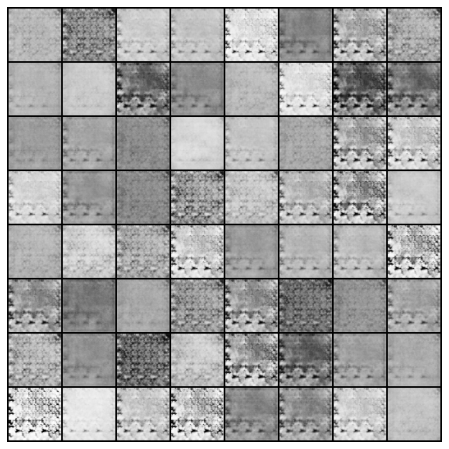

In [9]:
animate_gen_imgs()

# Trian : izif E

In [10]:
DC.eval()
D.eval()

kappa = 1.0
EC_losses = []

iters = 0
AE_img_list = []

def train_AE(epoch):
    global epochs
    global iters
    global EC_losses
    global AE_img_list
    
    # 인덱스 0부터 세기 시작
    # data[0].size():64x1x64x64(image) / data[1].size():64(label)
    for i,data in enumerate(data_loader,0):
        
        real_imgs = data[0].to(device)
        
        EC_optimizer.zero_grad()
        
        EC_validity = EC(real_imgs)
        
        fake_imgs = DC(EC_validity)
        
        _, real_features = D.forward(real_imgs)
        _, fake_features = D.forward(fake_imgs)
        
        
        # izif architecture
        imgs_loss = AE_criterion(real_imgs, fake_imgs)
        features_loss = AE_criterion(real_features, fake_features)
        EC_loss = imgs_loss + kappa*features_loss
        
        EC_loss.backward()
        EC_optimizer.step()
        
        # =============================================================
        # print
        # =============================================================
        print('[%d/%d][%d/%d]\n- E_loss: %.4f\n'
              %(epoch+1, epochs, i, len(data_loader), EC_loss.item()))
        
        # Save Losses for plotting later
        EC_losses.append(EC_loss.item())
        
        #Check how the generator is doing by saving G's output on noise_z
        if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(data_loader)-1)):
            with torch.no_grad():
                fake = DC(EC_validity).detach().cpu()
            AE_img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
        
#torch.save(E.state_dict(), 'E.ckpt')

In [11]:
for epoch in range(epochs):
    train_AE(epoch)

[1/100][0/15]
- E_loss: 0.0881

[1/100][1/15]
- E_loss: 0.0867

[1/100][2/15]
- E_loss: 0.0812

[1/100][3/15]
- E_loss: 0.0864

[1/100][4/15]
- E_loss: 0.0955

[1/100][5/15]
- E_loss: 0.0921

[1/100][6/15]
- E_loss: 0.0630

[1/100][7/15]
- E_loss: 0.0621

[1/100][8/15]
- E_loss: 0.0684

[1/100][9/15]
- E_loss: 0.0838

[1/100][10/15]
- E_loss: 0.0780

[1/100][11/15]
- E_loss: 0.0942

[1/100][12/15]
- E_loss: 0.0694

[1/100][13/15]
- E_loss: 0.0685

[1/100][14/15]
- E_loss: 0.0907

[2/100][0/15]
- E_loss: 0.0705

[2/100][1/15]
- E_loss: 0.0614

[2/100][2/15]
- E_loss: 0.0634

[2/100][3/15]
- E_loss: 0.0585

[2/100][4/15]
- E_loss: 0.0548

[2/100][5/15]
- E_loss: 0.0610

[2/100][6/15]
- E_loss: 0.0645

[2/100][7/15]
- E_loss: 0.0511

[2/100][8/15]
- E_loss: 0.0628

[2/100][9/15]
- E_loss: 0.0518

[2/100][10/15]
- E_loss: 0.0575

[2/100][11/15]
- E_loss: 0.0563

[2/100][12/15]
- E_loss: 0.0408

[2/100][13/15]
- E_loss: 0.0545

[2/100][14/15]
- E_loss: 0.0728

[3/100][0/15]
- E_loss: 0.0486

[17/100][12/15]
- E_loss: 0.0457

[17/100][13/15]
- E_loss: 0.0394

[17/100][14/15]
- E_loss: 0.0490

[18/100][0/15]
- E_loss: 0.0403

[18/100][1/15]
- E_loss: 0.0367

[18/100][2/15]
- E_loss: 0.0428

[18/100][3/15]
- E_loss: 0.0341

[18/100][4/15]
- E_loss: 0.0422

[18/100][5/15]
- E_loss: 0.0353

[18/100][6/15]
- E_loss: 0.0478

[18/100][7/15]
- E_loss: 0.0369

[18/100][8/15]
- E_loss: 0.0470

[18/100][9/15]
- E_loss: 0.0417

[18/100][10/15]
- E_loss: 0.0464

[18/100][11/15]
- E_loss: 0.0397

[18/100][12/15]
- E_loss: 0.0501

[18/100][13/15]
- E_loss: 0.0345

[18/100][14/15]
- E_loss: 0.0477

[19/100][0/15]
- E_loss: 0.0405

[19/100][1/15]
- E_loss: 0.0464

[19/100][2/15]
- E_loss: 0.0406

[19/100][3/15]
- E_loss: 0.0307

[19/100][4/15]
- E_loss: 0.0448

[19/100][5/15]
- E_loss: 0.0453

[19/100][6/15]
- E_loss: 0.0421

[19/100][7/15]
- E_loss: 0.0409

[19/100][8/15]
- E_loss: 0.0412

[19/100][9/15]
- E_loss: 0.0413

[19/100][10/15]
- E_loss: 0.0372

[19/100][11/15]
- E_loss: 0.0381



[34/100][3/15]
- E_loss: 0.0356

[34/100][4/15]
- E_loss: 0.0393

[34/100][5/15]
- E_loss: 0.0420

[34/100][6/15]
- E_loss: 0.0443

[34/100][7/15]
- E_loss: 0.0387

[34/100][8/15]
- E_loss: 0.0368

[34/100][9/15]
- E_loss: 0.0332

[34/100][10/15]
- E_loss: 0.0472

[34/100][11/15]
- E_loss: 0.0426

[34/100][12/15]
- E_loss: 0.0368

[34/100][13/15]
- E_loss: 0.0466

[34/100][14/15]
- E_loss: 0.0430

[35/100][0/15]
- E_loss: 0.0497

[35/100][1/15]
- E_loss: 0.0387

[35/100][2/15]
- E_loss: 0.0427

[35/100][3/15]
- E_loss: 0.0365

[35/100][4/15]
- E_loss: 0.0477

[35/100][5/15]
- E_loss: 0.0399

[35/100][6/15]
- E_loss: 0.0425

[35/100][7/15]
- E_loss: 0.0408

[35/100][8/15]
- E_loss: 0.0417

[35/100][9/15]
- E_loss: 0.0375

[35/100][10/15]
- E_loss: 0.0490

[35/100][11/15]
- E_loss: 0.0397

[35/100][12/15]
- E_loss: 0.0358

[35/100][13/15]
- E_loss: 0.0371

[35/100][14/15]
- E_loss: 0.0427

[36/100][0/15]
- E_loss: 0.0409

[36/100][1/15]
- E_loss: 0.0352

[36/100][2/15]
- E_loss: 0.0474



[50/100][9/15]
- E_loss: 0.0505

[50/100][10/15]
- E_loss: 0.0313

[50/100][11/15]
- E_loss: 0.0408

[50/100][12/15]
- E_loss: 0.0410

[50/100][13/15]
- E_loss: 0.0394

[50/100][14/15]
- E_loss: 0.0376

[51/100][0/15]
- E_loss: 0.0380

[51/100][1/15]
- E_loss: 0.0530

[51/100][2/15]
- E_loss: 0.0486

[51/100][3/15]
- E_loss: 0.0455

[51/100][4/15]
- E_loss: 0.0326

[51/100][5/15]
- E_loss: 0.0478

[51/100][6/15]
- E_loss: 0.0418

[51/100][7/15]
- E_loss: 0.0361

[51/100][8/15]
- E_loss: 0.0425

[51/100][9/15]
- E_loss: 0.0346

[51/100][10/15]
- E_loss: 0.0425

[51/100][11/15]
- E_loss: 0.0422

[51/100][12/15]
- E_loss: 0.0367

[51/100][13/15]
- E_loss: 0.0329

[51/100][14/15]
- E_loss: 0.0395

[52/100][0/15]
- E_loss: 0.0339

[52/100][1/15]
- E_loss: 0.0491

[52/100][2/15]
- E_loss: 0.0407

[52/100][3/15]
- E_loss: 0.0529

[52/100][4/15]
- E_loss: 0.0487

[52/100][5/15]
- E_loss: 0.0330

[52/100][6/15]
- E_loss: 0.0416

[52/100][7/15]
- E_loss: 0.0341

[52/100][8/15]
- E_loss: 0.0406



KeyboardInterrupt: 

# Loss Graph

In [ ]:
def plot_train_loss():
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(DC_losses, label="G")
    plt.plot(D_losses, label="D")
    plt.plot(EC_losses, label="E")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [ ]:
plot_train_loss()

---

# Test Data

In [ ]:
#test_data_root = "../../dataset/test/test_DualPhaseSteel"
DP_test_data_root = "../../dataset/test/test_DualPhaseSteel"

test_data_set = dataset.ImageFolder(root = DP_test_data_root, # test_data_root,
                           transform = transforms.Compose([
                                  transforms.Resize(img_size),
                                  transforms.CenterCrop(img_size),
                                  torchvision.transforms.Grayscale(channel),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,),(0.5,))
                              ]))

# 배치로 나누고 셔플하기
test_data_loader = torch.utils.data.DataLoader(test_data_set, batch_size = 1,
                                              shuffle = False, num_workers = workers)

# 이상 픽셀 수 확인 함수

In [ ]:
def count_el_not_0(diff_img):
    count_el_not_0 = 0
    
    col_size = diff_img.shape[0]
    row_size = diff_img.shape[1]
    
    #print(col_size, row_size)
    
    for col in range(col_size):
        for row in range(row_size):
            if diff_img[col][row] != 0:
                count_el_not_0 += 1
                
    return count_el_not_0

# img 비교 함수

In [ ]:
def compare_imgs(real_img, generated_img, i, score, reverse=False, threshold=50):
    real_img = real_img.cpu().data.numpy().reshape(img_size, img_size) * 255
    generated_img = generated_img.cpu().data.numpy().reshape(img_size, img_size) * 255
    
    negative = np.zeros_like(real_img)

    if not reverse:
        diff_img = real_img - generated_img
    else:
        diff_img = generated_img - real_img

    diff_img[diff_img <= threshold] = 0

    # 분율 추출
    diff_cnts.append(count_el_not_0(diff_img))
    # 분산 추출
    diff_points.append(np.where(diff_img > threshold))
    
    anomaly_img = np.zeros(shape=(img_size, img_size, 3))
    anomaly_img[:, :, 0] = real_img - diff_img
    anomaly_img[:, :, 1] = real_img - diff_img
    anomaly_img[:, :, 2] = real_img - diff_img
    anomaly_img[:, :, 0] = anomaly_img[:,:,0] + diff_img
    anomaly_img = anomaly_img.astype(np.uint8)

    # anomaly_img 추출
    anomaly_imgs.append(anomaly_img)
    
    fig, plots = plt.subplots(1, 4)

    fig.suptitle(f'Anomaly - (anomaly score: {score:.4})')
    
    fig.set_figwidth(9)
    fig.set_tight_layout(True)
    plots = plots.reshape(-1)
    plots[0].imshow(real_img, cmap='gray', label = "real")
    plots[1].imshow(generated_img, cmap='gray')
    plots[2].imshow(diff_img, cmap='gray')
    plots[3].imshow(anomaly_img)
    
    plots[0].set_title('real')
    plots[1].set_title('generated')
    plots[2].set_title('difference')
    plots[3].set_title('Anomaly Detection')
    plt.show()

# Test

In [ ]:
diff_cnts = []
diff_points = []
anomaly_imgs = []

ano_criterion = nn.MSELoss()
DC.eval()
D.eval()
EC.eval()

# with open("score.csv", "w") as f:
#         f.write("label,img_distance,anomaly_score,z_distance\n")

for i, data in enumerate(test_data_loader, 0):
    real_img = data[0].to(device)

    real_z = EC(real_img) # 진짜 이미지의 latent vector
    fake_img = DC(real_z) # DC에 넣어서 가짜 이미지 생성.
    fake_z = EC(fake_img) # torch.Size([1, 100]) --> latent 진짜 이미지와 매핑된 가짜 이미지의 latent vector

    _, real_feature = D.forward(real_img) # 1, 256
    _, fake_feature = D.forward(fake_img)

    img_distance = ano_criterion(fake_img, real_img)
    loss_feature = ano_criterion(fake_feature, real_feature)

    anomaly_score = img_distance + kappa*loss_feature

    z_distance = ano_criterion(fake_z, real_z)
    
#     with open("score.csv", "a") as f:
#             f.write(f"{label.item()},{img_distance},"
#                     f"{anomaly_score},{z_distance}\n")
            
#     print(f"{label.item()}, {img_distance}, "
#           f"{anomaly_score}, {z_distance}\n")
    compare_imgs(real_img, fake_img, i, anomaly_score, reverse = False, threshold = 0.3)

---

# 분율 추출

In [ ]:
diff_cnts = np.array(diff_cnts)

diff_fraction = diff_cnts / img_size ** 2

print(diff_fraction)

---

# 분산 추출

In [ ]:
from scipy import stats
from extended_int import int_inf

corr_coeffis = []
corr_p_vals = []

def cal_corr_coeffis():
    for idx in range(len(test_data_loader)):
        x_points = diff_points[idx][0]
        y_points = diff_points[idx][1]
        
        
        if len(x_points) > 0:
            corr_coeffi, corr_p_val = stats.pearsonr(x_points, y_points)
        else:
            corr_coeffi, corr_p_val = -int_inf, -int_inf
        
        corr_coeffis.append(corr_coeffi)
        corr_p_vals.append(corr_p_val)

In [ ]:
cal_corr_coeffis()

print(corr_coeffis)

---

# 모델 저장 및 읽기

In [ ]:
save_file = "./pretrained/pretrained.pth"

def save_pretrained():
    pretrained = {
        "D" : D.state_dict(),
        "DC" : DC.state_dict(),
        "EC" : EC.state_dict()
    }

    if not os.path.isdir("pretrained"):
        os.mkdir("pretrained")
    torch.save(pretrained, save_file)

In [ ]:
save_pretrained()

In [ ]:
pretrained_D = Discriminator().to(device)
pretrained_DC = Decoder().to(device)
pretrained_EC = Encoder().to(device)

def load_pretrained():
    global pretrained_D
    global pretrained_DC
    global pretrained_EC
    
    assert os.path.isdir("pretrained"), "Error : no pretrained dir found!"
    
    pretrained = torch.load(save_file)
    
    pretrained_D.load_state_dict(pretrained["D"])
    pretrained_DC.load_state_dict(pretrained["DC"])
    pretrained_EC.load_state_dict(pretrained["EC"])
    
    #print("pretrained_D :", pretrained_D)
    #print("pretrained_G :", pretrained_DC)
    #print("pretrained_E :", pretrained_EC)

In [ ]:
load_pretrained()

In [ ]:
def test():
    ano_criterion = nn.MSELoss()
    pretrained_DC.eval()
    pretrained_D.eval()
    pretrained_EC.eval()

    # with open("score.csv", "w") as f:
    #         f.write("label,img_distance,anomaly_score,z_distance\n")

    for i, data in enumerate(test_data_loader, 0):
        real_img = data[0].to(device)

        real_z = pretrained_EC(real_img) # 진짜 이미지의 latent vector
        fake_img = pretrained_DC(real_z) # DC에 넣어서 가짜 이미지 생성.
        fake_z = pretrained_EC(fake_img) # torch.Size([1, 100]) --> latent 진짜 이미지와 매핑된 가짜 이미지의 latent vector

        _, real_feature = pretrained_D.forward(real_img) # 1, 256
        _, fake_feature = pretrained_D.forward(fake_img)

        img_distance = ano_criterion(fake_img, real_img)
        loss_feature = ano_criterion(fake_feature, real_feature)

        anomaly_score = img_distance + kappa*loss_feature

        z_distance = ano_criterion(fake_z, real_z)

    #     with open("score.csv", "a") as f:
    #             f.write(f"{label.item()},{img_distance},"
    #                     f"{anomaly_score},{z_distance}\n")

    #     print(f"{label.item()}, {img_distance}, "
    #           f"{anomaly_score}, {z_distance}\n")
        compare_imgs(real_img, fake_img, i, anomaly_score, reverse = False, threshold = 0.3)

In [ ]:
diff_cnts = []
diff_points = []
anomaly_imgs = []

corr_coeffis = []
corr_p_vals = []

test()

In [ ]:
diff_cnts = np.array(diff_cnts)

diff_fraction = diff_cnts / img_size ** 2

print(diff_fraction)

In [ ]:
cal_corr_coeffis()

print(corr_coeffis)

---

# anomaly detection 이미지 추출

In [ ]:
anomaly_imgs

# 이미지 저장 함수

In [ ]:
import cv2

def save_imgs(folder, imgs):
    if not os.path.isdir("anomaly_imgs"):
        os.mkdir("anomaly_imgs")
    
    for i in range(len(imgs)):
        cv2.imwrite('%s/%d.png' %(folder,i), imgs[i]) #이미지 저장할 경로 설정을 여기서 한다.
    print("image saving complete")

In [ ]:
save_imgs("./anomaly_imgs", anomaly_imgs)

---

# 티타늄(Ti64) 상대 밀도 계산

In [ ]:
Ti64_density = 4.43

Ti64_rel_densitys = np.array([])

Ti64_rel_densitys = diff_fraction * Ti64_density

print(Ti64_rel_densitys)